In [12]:
%matplotlib inline

本文会使用字符RNN对单词进行分类。本文的训练时from strach的，因此不会使用torchtext中的相关函数，以便更好的了解NLP中的基本操作。

字符RNN将单词视为一个字符序列，每一步输出一个预测以及隐状态，并将前一步的隐状态喂给下一步。我们将最后一步的预测作为输出，也就是单词所属的类别。

具体的，我们将会使用来自18中语言的几千个surname进行训练，根据一个单词的拼写来预测一个name属于哪种语言。

最终的预测效果如下所示：
```
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```

# 准备数据

从[这里](https://download.pytorch.org/tutorial/data.zip)下载所需的数据集，并置于当前文件夹下。

`data/name`文件夹包含了18个以“[语言].txt”命名的文件。每个文件包含一组名字，每个名字占一行。

我们将名字存在一个字典中：`{language: [names ...]}`。

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


In [2]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## 将名字转化为tensor

现在需要将名字转化为tensor，以便之后的训练。

我们使用“one-hot vector”来对单词进行表示。如`"b" = <0 1 0 0 ...>`。

我们使用一个2维矩阵来表示一组单词 `<line_length x 1 x n_letters>`，增加了额外一维的原因是pytorch使用batch的形式来训练。

In [3]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


# 搭建网络

RNN模型包含了两个线性层，分别用于处理输入和隐状态，并在输出之后接一个LogSoftmax。网络结构如下图所示：

![网络结构](https://i.imgur.com/Z2xbySO.png)

In [4]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

为了让网络跑起来，需要将一个输入和前一步的隐状态喂给网络。

In [5]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9507, -2.8605, -2.8195, -2.8011, -2.8884, -2.8568, -3.0077, -2.8821,
         -2.8894, -2.9618, -2.9754, -2.8000, -2.9035, -2.9804, -2.9418, -2.8480,
         -2.8415, -2.8526]], grad_fn=<LogSoftmaxBackward>)


输出是一个`<1 x n_categories>`的tensor，对应单词属于每个类别的likelihood。

# 训练

## 训练准备

首先定义一个辅助函数来对输出进行展示。我们使用`Tensor.topk`来获取最大值的索引。

In [6]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Korean', 11)


此外，还需要快速获取输入示例，即name和language。

In [7]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Chinese / line = Law
category = Greek / line = Leontarakis
category = Scottish / line = Ramsay
category = Japanese / line = Ashida
category = Greek / line = Strilakos
category = Czech / line = Navara
category = Scottish / line = Black
category = Arabic / line = Hanania
category = Spanish / line = Castillion
category = Chinese / line = Kwan


## 训练网络

现在需要将一组输入数据喂给网络，让它进行预测，然后告诉网络他预测对了没有。


由于RNN的最后一层是`nn.LogSofmax`，损失函数我们使用`nn.NLLLoss`。

In [8]:
criterion = nn.NLLLoss()

每次训练包括以下几个步骤：

- Create input and target tensors
- Create a zeroed initial hidden state
- Read each letter in and
    - Keep hidden state for next letter
- Compare final output to target
- Back-propagate
- Return the output and loss

In [9]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

一切准备就绪。现在可以开始训练了。

In [10]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 2.2438 Nardovino / Russian ✗ (Italian)
10000 10% (0m 14s) 3.0031 Hill / Korean ✗ (Scottish)
15000 15% (0m 20s) 2.2323 Dinko / Polish ✗ (Czech)
20000 20% (0m 28s) 2.1661 Hermann / Dutch ✗ (German)
25000 25% (0m 35s) 1.6489 Kuai / Chinese ✓
30000 30% (0m 42s) 1.1675 Egami / Japanese ✓
35000 35% (0m 49s) 1.8340 Snell / Scottish ✗ (Dutch)
40000 40% (0m 56s) 0.8857 Cunningham / Scottish ✓
45000 45% (1m 2s) 1.0475 Mizoguchi / Italian ✗ (Japanese)
50000 50% (1m 10s) 1.1746 Sobol / Polish ✓
55000 55% (1m 17s) 0.2792 Asghar / Arabic ✓
60000 60% (1m 24s) 0.1404 Gribanovsky / Russian ✓
65000 65% (1m 31s) 1.1786 Ortiz / Spanish ✓
70000 70% (1m 38s) 2.2380 Samios / Portuguese ✗ (Greek)
75000 75% (1m 45s) 0.0458 Arnoni / Italian ✓
80000 80% (1m 52s) 0.8180 Mathieu / French ✓
85000 85% (1m 59s) 2.1858 Nowak / Polish ✗ (Czech)
90000 90% (2m 6s) 2.4885 Clark / Irish ✗ (Scottish)
95000 95% (2m 13s) 0.5073 Banh / Vietnamese ✓
100000 100% (2m 20s) 2.0309 Rhys / Korean ✗ (Irish)


## 打印结果

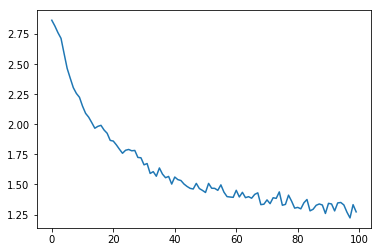

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## 结果评估

为了观察测试结果在不同类型上的表现，我们创建一个混淆矩阵，表明对于每种类型的语言（行），网络的实际预测结果是什么样的（列）。

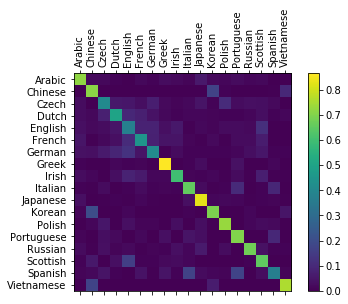

In [14]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

你可以沿着横轴的挑选亮点，看看网络在哪些地方猜错了，比如Chinese for Korean, and Spanish for Italian。可以发现，网络对Greek预测的很好，但是在English上的表现结果很差，这大概是由于英语名字和其他语言重叠的部分太多了。

## 对用户输入进行测试

In [15]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.73) Russian
(-0.90) Czech
(-3.10) English

> Jackson
(-0.25) Scottish
(-2.20) English
(-2.78) Russian

> Satoshi
(-0.80) Japanese
(-1.31) Italian
(-2.56) Arabic
